In [1]:

import torch
import numpy
from utils.util import *
from main import *
from torch.utils.data import DataLoader
import torch.nn as nn
from antenna_array_conversion.true_function import *
import antenna_array_conversion.torch_function as top

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = NN2(2048, 1, 8, 8, nn.ReLU)
model.load_state_dict(torch.load('weights/NN2_CostScaled_8_8_ReLU.pth'))

<All keys matched successfully>

In [3]:
train = DataLoader(AntDataset('data/large/scaled_cost/YZ_Large_70_Cost_Scaled.npz'))
test = DataLoader(AntDataset('data/large/scaled_cost/YZ_Large_30_Cost_Scaled.npz'))

In [4]:
## smaller scale
given_shapes = pd.read_csv('top_10_arrays.csv')

In [5]:
first_shape = torch.from_numpy(given_shapes.iloc[1, :-1].values.astype(np.float32))

In [6]:
first_shape[first_shape[:1024].nonzero()].squeeze()

tensor([-30.7598, -29.2138, -27.6677, -31.0370, -29.4910, -27.9450, -26.3990,
        -24.8529, -23.3069, -29.7682, -28.2222, -26.6762, -25.1302, -23.5841,
        -22.0381, -20.4921, -30.0455, -28.4994, -26.9534, -25.4074, -23.8614,
        -22.3154, -20.7693, -19.2233, -28.7767, -27.2307, -25.6846, -24.1386,
        -22.5926, -21.0466, -19.5006, -17.9545, -27.5079, -25.9619, -24.4159,
        -22.8698, -21.3238, -19.7778, -18.2318, -24.6931, -23.1471, -21.6010,
        -20.0550, -18.5090, -16.9630, -20.3323, -18.7862, -17.2402, -15.0643,
        -14.8683, -14.6722, -14.4762, -13.6620, -13.4660, -13.2700, -13.0739,
        -12.8779, -12.6819, -12.4858, -11.6717, -11.4756, -11.2796, -11.0836,
        -10.8875, -10.6915, -10.4955,  -9.6813,  -9.4853,  -9.2892,  -9.0932,
         -8.8972,  -8.7011,  -8.5051,  -8.3091,  -7.6909,  -7.4949,  -7.2989,
         -7.1028,  -6.9068,  -6.7108,  -6.5147,  -6.3187,  -5.5045,  -5.3085,
         -5.1125,  -4.9164,  -4.7204,  -4.5244,  -4.3283,  -3.51

In [50]:
ParamsArray = top.InitializeParamsArray(device = device)

def gradient_wrt_input(model, ants, lr, noise_std, iters):
    model.eval()
    ants.requires_grad_(True)
    for i in range(iters):
        # show_arrays(ants)
        ants.grad.zero_()
        output = model(ants)
        output.backward()

        with torch.no_grad():
            candidate = ants - (lr * ants.grad * (ants != 0).float()) 
            dist = calculate_min_distance(dist)
            if dist < 0.5:
                print(f'{i} iteration - Distance: {dist}')
                continue
            ants = candidate
    return ants

optimized_ants = gradient_wrt_input(model, first_shape[:-1], 0.01, 0, 1000)
print(f'Optimized Dist - {calculate_min_distance(optimized_ants)}')
print(f'Optimized Cost: {top.CostFunArray(optimized_ants[:1024].to(device), optimized_ants[1024:].to(device), ParamsArray, device)}')

AttributeError: 'NoneType' object has no attribute 'zero_'

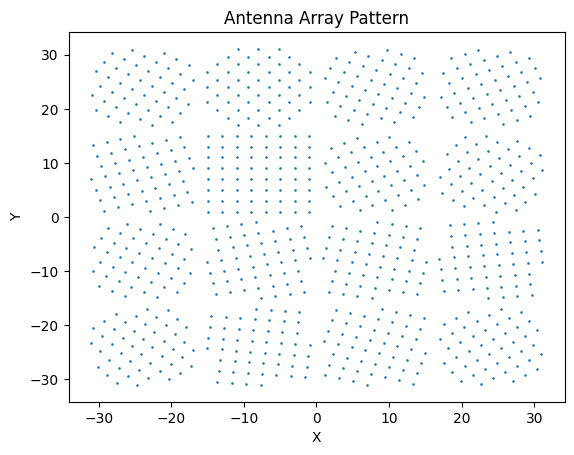

Antennas: 812.0


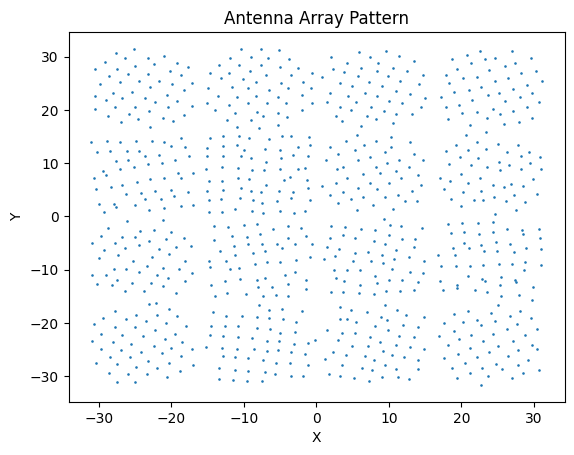

0.500731885433197

In [15]:
def optimized_gradient_wrt_input(model, ants, lr, noise_std, iters):
    model.eval()  # Ensure the model is in evaluation mode to disable dropout or batch norm layers from updating
    
    # Ensure ants tensor requires gradient computation for optimization
    ants.requires_grad_(True)
    last = ants.clone()
    for i in range(iters):
        if ants.grad is not None:
            ants.grad.zero_()  # Zero out the gradients to prevent accumulation from previous iterations
        
        output = model(ants)
        loss = output.sum()  # Assuming output is a loss value; modify accordingly if not
        loss.backward()  # Compute gradients with respect to ants
        
        with torch.no_grad():
            # Apply noise only to non-buffer elements; buffers are assumed to be marked by zero in ants
            noise = torch.rand_like(ants) * noise_std
            noise_masked = noise * (ants != 0).float()  # Apply noise only to non-zero elements
            
            # Instead of reassigning ants, update its values directly
            candidate = ants + (-lr * ants.grad * (ants != 0).float() + noise_masked)
            # ants.add_(-lr * ants.grad + noise_masked)  # In-place update
            if calculate_min_distance(candidate) < 0.5:
                # If constraints are not met, revert to the last valid configuration
                # Ensure this updates 'ants' in a way that retains its requires_grad property
                ants.data = last.data.clone()
                break
            else:
                # Update the last valid configuration if constraints are met
                ants.add((-lr * ants.grad * (ants != 0).float() + noise_masked))
        
        # Zero the gradients after each update to prepare for the next iteration
    
    return ants
def gradient_wrt_input(model, ants, lr, noise_std, iters):
    model.eval()
    last = None
    ants = ants.clone()
    ants.requires_grad_()
    for i in range(iters):
        if ants.grad is not None:
            ants.grad.zero_()
        output = model(ants)
        output.backward()

        with torch.no_grad():
            last = ants.clone()
            noise = torch.rand_like(ants) * noise_std
            ants -= (lr * ants.grad * (ants != 0).float())
            if calculate_min_distance(ants) < 0.5:
                return last

    return ants

show_arrays(first_shape)
print(f'Antennas: {torch.count_nonzero(first_shape)/2}')
optimized_ants = gradient_wrt_input(model, first_shape, 0.1, 0.01, 20000)
show_arrays(optimized_ants)
calculate_min_distance(optimized_ants)

In [10]:
first_shape.shape

torch.Size([2048])

# Introduce Penalty Terms

In [24]:
def pen(x):
    if x <= 0.5:
        return torch.tensor([float('inf')])
    return torch.log(torch.tensor((1/(x-0.5))))
eps = 1e-6
eps * pen(0.500000000)

tensor([inf])

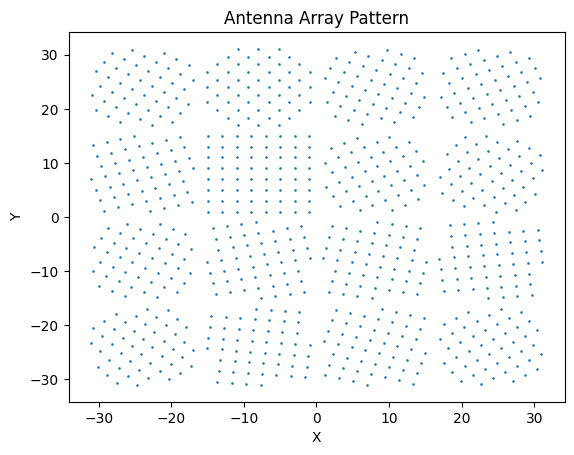

Antennas: 812.0
Evaluation: tensor([-2.6941], grad_fn=<AddBackward0>)
Antennas: 812.0
Evaluation: tensor([-4.1620], grad_fn=<AddBackward0>)


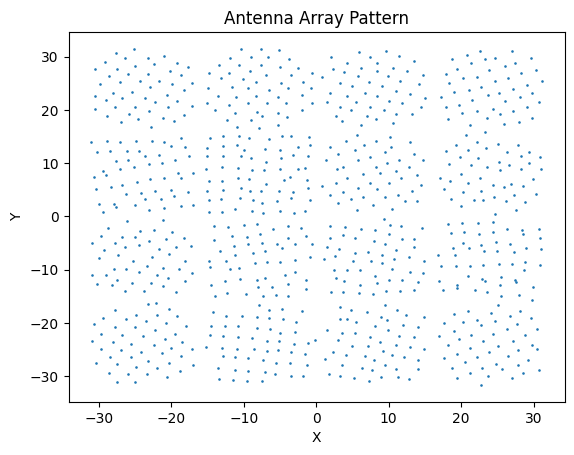

0.5

In [30]:

def gradient_w_pen(model, ants, lr, eps = 1e-6, penalty = lambda x: x, iters = 100):
    model.eval()
    last = None
    ants = ants.clone()
    ants.requires_grad_()
    for i in range(iters):
        if ants.grad is not None:
            ants.grad.zero_()
        output = model(ants)
        dist = calculate_min_distance(ants)
        cost = output + (eps * penalty(dist))
        cost.backward()

        with torch.no_grad():
            last = ants.clone()
            noise = torch.rand_like(ants)
            ants -= (lr * ants.grad * (ants != 0).float())
            if calculate_min_distance(ants) < 0.5:
                return last
    return ants

show_arrays(first_shape)
print(f'Antennas: {torch.count_nonzero(first_shape)/2}')
print(f'Evaluation: {model(first_shape)}')
optimized_ants = gradient_w_pen(model, first_shape, 0.01, 1e-6, pen, iters=100000)
print(f'Antennas: {torch.count_nonzero(optimized_ants)/2}')
print(f'Evaluation: {model(optimized_ants)}')
show_arrays(optimized_ants)
calculate_min_distance(optimized_ants)


In [34]:
exp(0.5000001)

100000.00005263559

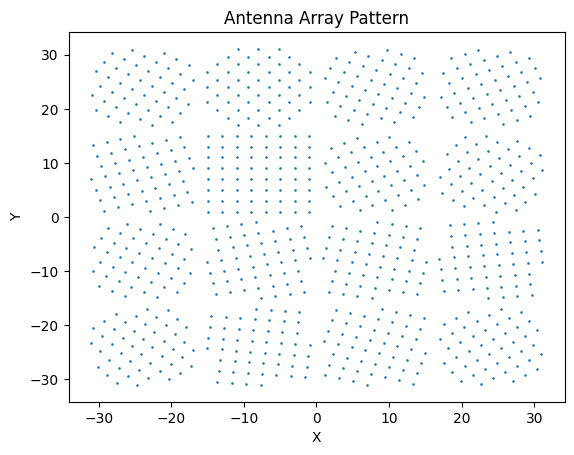

Antennas: 812.0


KeyboardInterrupt: 

In [27]:
import torch

def project_onto_constraint(ants, min_dist=0.5):
    """
    Projects antenna positions to satisfy the minimum distance constraint.
    This is a simple pairwise correction approach; more sophisticated methods might be needed for complex cases.
    """
    for i in range(ants.size(0)):
        for j in range(i + 1, ants.size(0)):
            diff = ants[j] - ants[i]
            dist = torch.norm(diff)
            if dist < min_dist:
                correction = (min_dist - dist) / 2
                if dist > 0:  # To avoid division by zero
                    direction = diff / dist
                    ants[i] -= correction * direction
                    ants[j] += correction * direction
    return ants

def gradient_w_adam_projection(model, ants_initial, lr, iters=100, min_dist=0.5):
    model.eval()
    ants = ants_initial.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([ants], lr=lr)

    for i in range(iters):
        optimizer.zero_grad()
        output = model(ants)
        cost = output
        cost.backward()
        optimizer.step()
        
        # Project antenna positions to satisfy the minimum distance constraint after the optimization step
        with torch.no_grad():
            ants[:] = project_onto_constraint(ants.clone().detach(), min_dist)

    return ants
show_arrays(first_shape)
print(f'Antennas: {torch.count_nonzero(first_shape)/2}')
optimized_ants = gradient_w_adam_projection(model, first_shape, 0.01, iters=10)
show_arrays(optimized_ants)
calculate_min_distance(optimized_ants)

In [7]:

top_10 = torch.from_numpy(pd.read_csv('top_10_arrays.csv').values[:, :-1].astype(np.float32))
top_10


tensor([[-30.6448, -29.7021, -28.7593,  ...,   0.0000,   0.0000,   0.0000],
        [-30.7598, -29.2138, -27.6677,  ...,   0.0000,   0.0000,   0.0000],
        [-31.0711, -29.6569, -28.2426,  ...,   0.0000,   0.0000,   0.0000],
        ...,
        [-30.3834, -28.7205, -27.0575,  ...,   0.0000,   0.0000,   0.0000],
        [-30.6448, -29.7021, -28.7593,  ...,   0.0000,   0.0000,   0.0000],
        [-30.3834, -28.7205, -27.0575,  ...,   0.0000,   0.0000,   0.0000]])

In [8]:
import torch

def yz_split(tensor):
    """
    Splits a 1D tensor into two parts, yant and zant, each taking half of the tensor.
    Then removes all trailing zeros from both parts.
    
    Args:
    - tensor (torch.Tensor): A 1D tensor with 2048 elements.
    
    Returns:
    - Tuple[torch.Tensor, torch.Tensor]: The two parts of the tensor with trailing zeros removed.
    """    
    # Split the tensor into yant and zant
    yant, zant = tensor.split(1024)
    
    # Function to remove trailing zeros from a tensor
    def remove_trailing_zeros(tensor):
        # Find the indices of non-zero elements and get the maximum index
        non_zero_indices = tensor.nonzero(as_tuple=True)[0]
        if len(non_zero_indices) == 0:  # If tensor is all zeros
            return tensor[:0]  # Return an empty tensor
        else:
            max_index = non_zero_indices.max()
            return tensor[:max_index + 1]
    
    # Remove trailing zeros from yant and zant
    yant = remove_trailing_zeros(yant)
    zant = remove_trailing_zeros(zant)
    
    return yant, zant

# Example usage:
# Assuming 'tensor' is your 1D tensor with 2048 elements
# tensor = torch.cat((torch.rand(1024) - 0.5, torch.zeros(1024)), 0)
yant, zant = yz_split(top_10[0])


In [11]:
ParamsArray = top.InitializeParamsArray()

In [14]:
for t in top_10:
    y,z = yz_split(t)
    print(top.CostFunArray(y.cuda(), z.cuda(), ParamsArray, device = device))

-40463.984375
-39931.296875
-39767.265625
-39472.40625
-39431.63671875
-39383.21875
-39036.94140625
-38702.12890625
-38690.56640625
-38600.6953125


NN2(
  (regressor): Sequential(
    (0): Linear(in_features=2048, out_features=8, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=8, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

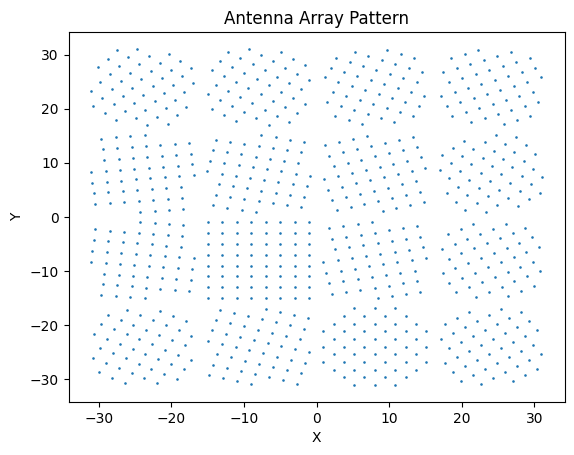

In [18]:
show_arrays(top_10[0])